In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu
import statsmodels.formula.api as smf 

In [2]:
ab_orders=pd.read_csv('ab_orders.csv')
ab_products=pd.read_csv('ab_products.csv')
ab_users_data=pd.read_csv('ab_users_data.csv')

In [3]:
ab_orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [4]:
ab_products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [5]:
ab_users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


Для оценки пользы новой системы рекомендаций приложения выбираем метрики: предположим, что она должна повышать количество
заказов, количество купленных товаров и стоимость заказа. Н0: новая система не влияет на 1) количество заказов, 2)количество
товара в заказе и 3)общую стоимость заказа, различий между группами по этим метрикам нет. Н1: различия есть. Проверим:

In [6]:
#Посмотрим на количество наблюдений в 2х группах:
ab_users_data.groupby('group', as_index=False).agg({'user_id':'nunique'})

,group,user_id
0,0,515
1,1,502


In [7]:
#Преобразуем и объединим дф
ab_orders.product_ids = ab_orders.product_ids.apply(lambda x: x.replace('{','').replace('}','').split(','))

In [8]:
df = ab_users_data.merge(ab_orders, on='order_id')
df

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"[84, 8, 24]"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"[60, 41, 46]"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"[9, 62, 77]"


In [9]:
#Считаем количество заказов по группам, исключая удаленные заказы:
df=df.query('action != "cancel_order"')\
.groupby(['user_id', 'group'], as_index=False).agg({'order_id':'count'})\
.rename(columns={'order_id':'order_count'})
df

,user_id,group,order_count
0,964,0,2
1,965,1,9
2,966,0,1
3,967,1,5
4,968,0,3
...,...,...,...
1012,1976,1,5
1013,1977,1,4
1014,1978,1,7
1015,1979,1,6


In [10]:
df1=df.groupby(['group'], as_index=False).agg({'order_count':'sum'})
df1

,group,order_count
0,0,1609
1,1,2514


Посмотрим на эти различия на боксплотах:

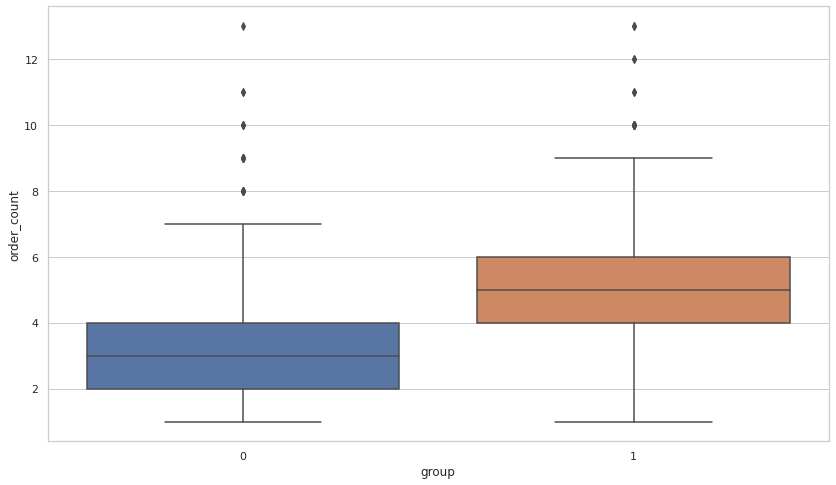

In [11]:

sns.set(style='whitegrid', rc={'figure.figsize' : (14,8)})
sns.boxplot(y='order_count', x='group', data = df)

Мы видим, что с учетом примерно одинаковых выборок в 2х группах, количество заказов в тестовой группе значительно больше.

In [12]:
#Проверим на нормальность распределения:
shapiro(df.query('group==0').order_count)

ShapiroResult(statistic=0.8348702788352966, pvalue=1.0818117861129074e-22)

In [13]:
shapiro(df.query('group==1').order_count)

ShapiroResult(statistic=0.9596871137619019, pvalue=1.7252431427916548e-10)

Так как распределения ненормальны, проведем тест Манна-Уитни на стат.значимость:

In [14]:
x=df.query('group==0').order_count.value_counts()
y=df.query('group==1').order_count.value_counts()

In [15]:
mannwhitneyu(x, y) 

MannwhitneyuResult(statistic=73.5, pvalue=0.8274361748127279)

Различия в 2х группах по количеству заказов статистически значимы!

Теперь посмотрим на количество товаров в заказе и общую стоимость заказа. Преобразуем и объеденим дф:

In [16]:
ab_orders=ab_orders.explode('product_ids').reset_index(drop=True).rename(columns={'product_ids':'product_id'})

In [17]:
ab_orders

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
1,1255,2022-08-26 00:00:19.000000,22
2,1255,2022-08-26 00:00:19.000000,53
3,1255,2022-08-26 00:00:19.000000,84
4,1256,2022-08-26 00:02:21.000000,56
...,...,...,...
13821,59487,2022-09-08 23:29:06.000000,9
13822,59487,2022-09-08 23:29:06.000000,62
13823,59487,2022-09-08 23:29:06.000000,77
13824,59533,2022-09-08 23:41:24.000000,17


In [18]:
users_orders= ab_users_data.merge(ab_orders, on='order_id')
users_orders

,user_id,order_id,action,time,date,group,creation_time,product_id
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56
...,...,...,...,...,...,...,...,...
14564,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,9
14565,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,62
14566,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,77
14567,1376,59533,create_order,2022-09-08 23:41:24.000000,2022-09-08,0,2022-09-08 23:41:24.000000,17


In [19]:
users_orders=users_orders.astype({'product_id':'int'})

In [20]:
all_df=users_orders.merge(ab_products, on='product_id')
all_df

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0
...,...,...,...,...,...,...,...,...,...,...
14564,1883,33910,create_order,2022-09-03 23:46:53.000000,2022-09-03,1,2022-09-03 23:46:53.000000,11,масло льняное,200.0
14565,1440,34742,create_order,2022-09-04 03:41:52.000000,2022-09-04,0,2022-09-04 03:41:52.000000,11,масло льняное,200.0
14566,1813,41998,create_order,2022-09-05 10:26:46.000000,2022-09-05,1,2022-09-05 10:26:46.000000,11,масло льняное,200.0
14567,1175,53851,create_order,2022-09-07 23:53:54.000000,2022-09-07,0,2022-09-07 23:53:54.000000,11,масло льняное,200.0


In [21]:
#Агрегируем нужные данные:
all_df=all_df.query('action != "cancel_order"')\
.groupby(['user_id','order_id', 'group'], as_index=False).agg({'product_id':'count', 'price':'sum'})\
.rename(columns={'product_id':'product_count', 'price':'sum_price'})
all_df

,user_id,order_id,group,product_count,sum_price
0,964,1255,0,4,408.7
1,964,1257,0,4,310.2
2,965,1256,1,3,250.5
3,965,3946,1,4,860.6
4,965,9097,1,6,608.2
...,...,...,...,...,...
4118,1980,57384,1,3,259.9
4119,1980,57498,1,4,239.0
4120,1980,58430,1,6,892.7
4121,1980,58460,1,3,203.2


In [22]:
#Считаем колличество всех заказанных товаров и их стоимость
df_count= all_df.groupby(['user_id','group'], as_index=False).agg({'product_count':'sum', 'sum_price':'sum'})
df_count

,user_id,group,product_count,sum_price
0,964,0,8,718.9
1,965,1,33,4155.5
2,966,0,2,85.0
3,967,1,18,1137.4
4,968,0,11,1590.7
...,...,...,...,...
1012,1976,1,16,2001.9
1013,1977,1,9,781.2
1014,1978,1,21,2766.6
1015,1979,1,26,2348.9


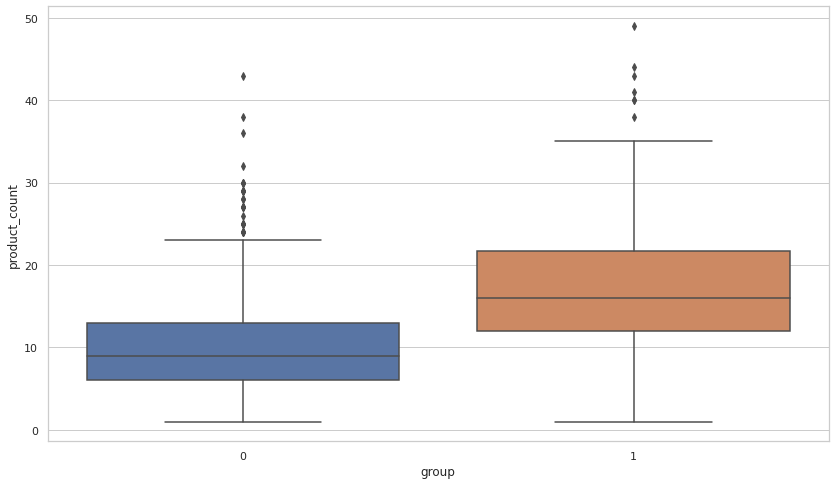

In [23]:
#Смотрим на распределение заказов и стоимости по группам на графиках:
sns.set(style='whitegrid', rc={'figure.figsize' : (14,8)})
sns.boxplot(y='product_count', x='group', data = df_count)

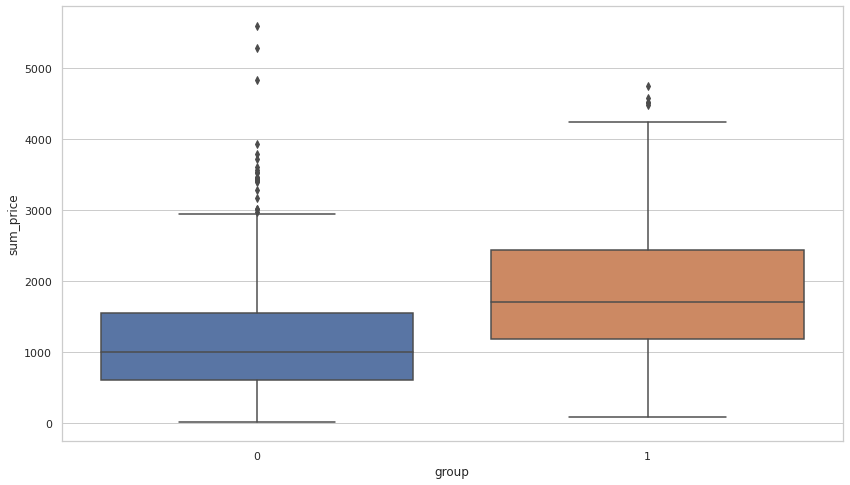

In [24]:
sns.set(style='whitegrid', rc={'figure.figsize' : (14,8)})
sns.boxplot(y='sum_price', x='group', data = df_count)

На графикax видно, что группа 1 расположена выше и имеет больший размах, медиана больше, чем у группы 0.
Посмотрим на описательную статистику групп:

In [25]:
df_count.query('group==0').product_count.describe()

count    515.000000
mean      10.466019
std        6.585587
min        1.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       43.000000
Name: product_count, dtype: float64

In [26]:
df_count.query('group==0').sum_price.describe()

count     515.000000
mean     1191.240388
std       829.633729
min        25.000000
25%       605.250000
50%       999.400000
75%      1553.200000
max      5589.800000
Name: sum_price, dtype: float64

In [27]:
df_count.query('group==1').product_count.describe()

count    502.000000
mean      16.804781
std        7.891336
min        1.000000
25%       12.000000
50%       16.000000
75%       21.750000
max       49.000000
Name: product_count, dtype: float64

In [28]:
df_count.query('group==1').sum_price.describe()

count     502.000000
mean     1851.059761
std       953.669817
min        83.500000
25%      1191.725000
50%      1710.300000
75%      2435.975000
max      4742.200000
Name: sum_price, dtype: float64

Мы видим, что по метрикам купленных товаров и стоимости заказа, все основные харрактеристики группы с новой системой 
рекомендаций выше, чем у группы 0 (mean, median(50%), std). Проведем тест на нормальность распределения:

In [29]:
shapiro(df_count.query('group==0').product_count)

ShapiroResult(statistic=0.9062955379486084, pvalue=2.880797765664543e-17)

In [30]:
shapiro(df_count.query('group==0').sum_price)

ShapiroResult(statistic=0.8932254314422607, pvalue=1.9053859323926758e-18)

In [31]:
shapiro(df_count.query('group==1').product_count)

ShapiroResult(statistic=0.9763003587722778, pvalue=2.86832403162407e-07)

In [32]:
shapiro(df_count.query('group==1').sum_price)

ShapiroResult(statistic=0.9757506847381592, pvalue=2.1518859227853682e-07)

Так как распределение в обеих группах ненормально, используем для анализа стат. значимости метод bootstrap. 

In [33]:
x=df_count[df_count.group==0]

In [34]:
stats.bootstrap((x.product_count, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=9.914563106796116, high=11.075728155339807), standard_error=0.2947423322773532)

In [35]:
stats.bootstrap((x.sum_price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1122.2597097906676, high=1265.697282164548), standard_error=36.42605593633045)

In [36]:
y=df_count[df_count.group==1]

In [37]:
stats.bootstrap((y.product_count, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=16.111553784860558, high=17.49601593625498), standard_error=0.35216925053106407)

In [38]:
stats.bootstrap((y.sum_price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1770.2514880899855, high=1934.3141066099824), standard_error=41.966637543881575)

Доверительные интервалы в обеих метриках не пересекаются - значит, мы получили статистически значимые различия между группами 
по этим метрикам. 

Вывод: исходя из того, что в группе с новой системой рекомендаций количество заказов значительно возросло, среднее количество 
заказываемых товаров увеличилось на 6 единиц, а суммарная стоимость заказов увеличилась более чем на 600 единиц, рекомендуем 
включить новую систему рекомендаций на всех пользователей.